# Solve the Linear Regression using Gradient Descent (with full-batch)

* Regression includes many techniques for modeling and analyzing several variables, when the focus is on the relationship between a dependent variable and one or more independent variables (or 'predictors'). [Ref.: Wikipedia, "Regression analysis" page](https://en.wikipedia.org/wiki/Regression_analysis)

# Problem:

$
y = f(\boldsymbol{x})
$

$
\hat{y} = y_{\textrm{pred}} = \boldsymbol{w}^{T}\boldsymbol{x} + b
= [b, \boldsymbol{w}^{T}] \begin{bmatrix}1\\ \boldsymbol{x}\end{bmatrix} 
$

or

$\hat{y} = w_{0}  x_{0} + w_{1} x_{1} + w_{2} x_{2} + \cdots + w_{d} x_{d},$

where $w_{0} = b$ , and $x_{0} = 1$

* $\mathbf{x} = \begin{bmatrix} x_{1} \\ x_{2}, \\ : \\ x_{d} \end{bmatrix} $
* $\mathbf{w} =  \begin{bmatrix} w_{1} \\ w_{2}, \\ : \\ w_{d} \end{bmatrix}$

Loss function: $\mathcal{L} = \sum_{i=0}^{N-1} (\hat{y}_{i} - y_{i})^{2}$
  * where $N$ is a number of examples

# Objective:

To find $[w_{0}, \boldsymbol{w}^{T}]$
Such that $\mathcal{L}$ is minimum


## Import

In [28]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib import animation
from IPython.display import HTML

from itertools import zip_longest

## Data generation

We make a simple dataset based on model which follows equation

$$y = a x + b + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, \sigma_{x})$$

where $a = 4$, $b = -3$, the error term $\varepsilon$ is sampled on normal distributon which variance $\sigma$ depends on the value of $x$ for educational purpose.

In [41]:
np.random.seed(219)
N=    100 #200
low= -3.0
high= 4.0


a=  4  # 斜率
b= -3  # y軸 截距

'''
data_y= np.zeros(N)
for i, x in enumerate(data_x):
  scale = - (x - low) * (x - high) / 3. + 1.5
  data_y[i] = a * x + b + np.random.normal(loc=0.0, scale=scale, size=1)
'''

def generateY(x, a=4, b=-3):
    ϵ= np.random.normal(
        loc=   0.0, 
        scale= np.random.normal(0,5), 
        size=x.shape)
    y= a*x +b +ϵ
    return y

data_x= np.random.uniform(low= low, 
                          high=high, 
                          size=N)
data_y= generateY(data_x, a, b)

data_x, data_y

(array([-2.90554617, -1.0668287 , -1.73680849, -1.09839978,  3.38210779,
         1.90804863, -0.06879004,  3.01302598,  0.81304938,  2.42260316,
         2.98117635,  3.61569454,  2.84030137, -1.23176639, -2.40653059,
        -0.16439895, -2.62659137, -1.75746004, -2.23447458,  0.99827394,
        -2.12737711,  2.3952684 , -1.28884105, -2.79278313,  0.43951765,
         3.20696986,  3.84074642,  2.96754471,  2.86043676,  0.50904794,
        -1.01022697, -0.16744371, -2.44744102,  2.8305713 , -1.00626668,
        -1.06944407, -1.64154844, -2.65921389,  1.39586421,  3.98770505,
         1.75021855, -0.99497801, -1.24944324,  3.73209535,  0.20262855,
         2.69593503, -1.44626584,  3.41722805,  3.93309567, -1.95690551,
         1.16547552,  0.77128732,  0.41956125, -1.63536161,  0.90810797,
         2.71172623,  2.7409153 ,  2.84130936,  2.32744133,  2.71660038,
         0.07070738,  3.75484871, -1.81727272, -1.57347911, -1.17590282,
        -1.03758217,  2.067583  , -1.3337423 , -1.8

### Data plot

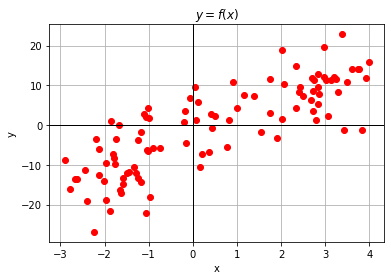

In [139]:
plt.plot(data_x, data_y, 'ro')
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('$y=f(x)$')
plt.grid()
plt.show()

## Exact solution of linear regression

Linear regression model is
$$y_{\textrm{pred}} = \boldsymbol{w}^{\top}\boldsymbol{x} + b$$
or
$$y_{\textrm{pred}} = w_{0} + w_{1} x_{1} + w_{2} x_{2} + \cdots + w_{d} x_{d},$$
where $w_{0} = b$.

Extend the class of models by considering linear combinations of fixed nonlinear functions of the input variables

$$y_{\textrm{pred}} = w_{0} + w_{1} \phi_{1}(\mathbf{x}) + w_{2} \phi_{2}(\mathbf{x}) + \cdots + w_{M-1} \phi_{M-1}(\mathbf{x}),$$

$$y_{\textrm{pred}} = w_{0} + \sum_{j}^{M-1} w_{j} \phi_{j}(\mathbf{x}).$$

$\phi_{j}(\mathbf{x})$ is called *basis function*.
And add dummy 'basis function' $\phi_{0}(\mathbf{x}) = 1$ so that

$$y_{\textrm{pred}} = \sum_{j}^{M-1} w_{j} \phi_{j}(\mathbf{x}) = \mathbf{w}^{\top} \boldsymbol{\phi}(\mathbf{x}).$$

### Normal Equation (analytic solution of linear model)

$$\mathbf{w} = (\mathbf{\Phi}^{\top} \mathbf{\Phi})^{-1} (\mathbf{\Phi}^{\top} \mathbf{Y})$$

where $\mathbf{\Phi}$ is a $N \times M$ matrix, called *design matrix*

$$\mathbf{\Phi} = \left( \begin{array}{llll}
\phi_{0}(\mathbf{x_{1}}) & \phi_{1}(\mathbf{x_{1}}) & \cdots & \phi_{M-1}(\mathbf{x_{1}})\\
\phi_{0}(\mathbf{x_{2}}) & \phi_{1}(\mathbf{x_{2}}) & \cdots & \phi_{M-1}(\mathbf{x_{2}})\\
\vdots & \vdots & \ldots & \vdots\\
\phi_{0}(\mathbf{x_{N}}) & \phi_{1}(\mathbf{x_{N}}) & \cdots & \phi_{M-1}(\mathbf{x_{N}})
\end{array} \right).$$

And $\mathbf{Y}$ is a target vector (label data)
* $\mathbf{Y} = [y_{1}, y_{2}, \cdots, y_{N}]^{\top}$

### Problem

* This is a our problem.
$$y_{\textrm{pred}} = w_{0} + w_{1} x,$$

$$y_{\textrm{pred}} = \sum_{j}^{M-1} w_{j} \phi_{j}(\mathbf{x}) = \mathbf{w}^{\top} \boldsymbol{\phi}(\mathbf{x}).$$

* Write $\mathbf{\Phi}$ on your paper
  1. First, write $\phi_{0}(\mathbf{x})$ and $\phi_{1}(\mathbf{x})$.
  2. Second, consider how the design matrix $\mathbf{\Phi}$ looks like

## Implementation of exact solution (Normal equation)

### 1. Implement $\Phi$, $\mathbf{Y}$

* X: $\Phi$
* Y: $\mathbf{Y}$

In [165]:
# using data_x, data_y
'''
X = np.concatenate((data_x.reshape(N, 1), 
                    np.ones(N).reshape(N, 1)), 
                   axis=1)
'''

Φ= np.concatenate((np.ones(N).reshape(N, 1),
                   data_x.reshape(N, 1)), 
                   axis=1)
Y= data_y.reshape(N, 1)


### 2. Implement $\mathbf{w} = (\mathbf{\Phi}^{\top} \mathbf{\Phi})^{-1} (\mathbf{\Phi}^{\top} \mathbf{Y})$

* A: $\mathbf{\Phi}^{\top} \mathbf{\Phi}$
* invA: inverse of A
* B: $\mathbf{\Phi}^{\top} \mathbf{Y}$
* W_exact: $\mathbf{w}$ with shape: (2,)
* matrix inversion: `np.linalg.inv(A)`

In [166]:

W_exact= np.linalg.inv(Φ.T @Φ) @ (Φ.T@Y)               #np.matmul(invA, B)

W_exact= np.squeeze(W_exact) #只是把矩陣形狀重整一下，沒做也沒關係。

#minima= W_exact.reshape(2, 1) # for 3D plot and contour plot
#minima

print("Real parameters used creating the data")
print(f"b=w0= {b:.4f}, a=w1= {a:.4f} ")
print("Exact Solution using the normal equation")
print(f"w0: {W_exact[0]:.4f}  w1: {W_exact[1]:.4f}")

Real parameters used creating the data
b=w0= -3.0000, a=w1= 4.0000 
Exact Solution using the normal equation
w0: -2.4039  w1: 4.1776


## Training Pseudo Code using Gradient Descent

```python
for epoch in max_epochs: # one epoch: when an ENTIRE dataset is passed through the model only ONCE
  for step in num_batches: # num_batches = int(data_size / batch_size)
    1. sampling mini-batches with batch_size
      1-1. data augmentation (when you need)
    2. calculate the logits # logits = f(x)
    3. calculate the loss # loss = loss(logits, labels)
    4. calculate the gradient with respect to weights
    5. update weights
```

## Build a LinearRegression model

In [155]:
class LinearRegression(object):
    
  def __init__(self, data_x, data_y,
               w_init=None, 
               b_init=None, 
               learning_rate=0.1):
    
    # a, b 須來自外部 global, 這樣不好！改...
    
    #scale = 4.0 #改後就用不到了
    
    
    if w_init is not None:
      self.w = w_init
    else:
      self.w = np.random.uniform(-1,1) #(low=a-scale, high=a+scale)
    
    if b_init is not None:
      self.b = b_init
    else:
      self.b = np.random.uniform(-1,1) #(low=b-scale, high=b+scale)
    print("w_init: {:.3f}".format(self.w))
    print("b_init: {:.3f}".format(self.b))
      
    self.x= data_x
    self.y= data_y
    self.lr = learning_rate
    
    # for accumulation of loss and path (w, b)
    self.loss_history = []
    self.w_history = []
    self.b_history = []
  
  def inference(self, x):
    """Inference function for a linear model
      y_pred = w * x + b.
      
      # 這函數就是計算 prediction value，我也許會直接命名為 def predict()
    
    Args:
      x: full-batch data, shape: (1-rank Tensor (vector) np.array)
    
    Returns:
      y_pred: full-batch y_pred, shape: (1-rank Tensor (vector) np.array)
    
    """
    y_pred= self.w *x +self.b
    return y_pred
  
  def loss_for_plot(self, w, b):
    """List of loss function with respect to given list of (w, b).
      
    Args:
      w: shape: (1-rank Tensor (vector) np.array)
      b: shape: (1-rank Tensor (vector) np.array)
    
    Returns:
      loss_for_plot: shape: (1-rank Tensor (vector) np.array)
    """
    y_pred= np.matmul(
             np.expand_dims(self.x, axis=1), 
             np.expand_dims(w, axis=0)
            ) + b
    
    loss_for_plot= 0.5 * (y_pred - np.expand_dims(self.y, axis=1))**2
    loss_for_plot= np.mean(loss_for_plot, axis=0)
    return loss_for_plot
  
  def loss_fn(self, labels, predictions):
    """Loss function.
    MSE loss
    
    Args:
      labels: target data y, shape: (1-rank Tensor (vector) np.array)
      predictions: model inference y_pred, shape: (1-rank Tensor (vector) np.array)
    
    Returns:
      loss: mean value of loss for full-batch data, shape: (0-rank Tensor (scalar))
    """
    #loss = 0.5 * np.mean((predictions - labels)**2)
    
    # 嚴格來講，正確的理論形式應該如下：
    loss= np.sum((predictions - labels)**2)
    
    return loss
  
  def loss_derivative(self):
    """Loss derivative.
    
    Returns:
      dw: dL / dw, mean value of derivatives for full-batch data, shape: (0-rank Tensor (scalar))
      db: dL / db, mean value of derivatives for full-batch data, shape: (0-rank Tensor (scalar))
    """
    #dw= np.mean((self.y_pred - self.y) * self.x)
    #db= np.mean(self.y_pred - self.y)
    
    # 嚴格來講，正確的理論形式應該如下：
    dw= np.sum((self.y_pred - self.y) * self.x) *2
    db= np.sum(self.y_pred - self.y) *2
    
    # 但如果是這樣，它的值較大，要讓 learning rate 更小一點，否則每一步太大會發散！
    
    return dw, db
  
  def weights_update(self):
    """Weights update using Gradient descent.
    
      w' = w - lr * dL/dw
    """
    self.w = self.w - self.lr * self.dw
    self.b = self.b - self.lr * self.db
    
  def history_update(self, loss, w, b):
    """Accumulate all interesting variables
    """
    self.loss_history.append(loss)
    self.w_history.append(w)
    self.b_history.append(b)


  def train(self, max_epochs=100):
    
    pre_loss = 0.0
    for epoch in range(max_epochs):
      
      self.y_pred= self.inference(self.x) # 這行就是計算 prediction value
    
      self.loss=   self.loss_fn(self.y, self.y_pred)
      self.history_update(self.loss, self.w, self.b)
      
      if epoch % 10 == 0:
        print("epochs: {}  loss: {:.6f}  w: {:.5f}  b: {:.5f}"
              .format(epoch, self.loss, self.w, self.b))
      
      self.dw, self.db= self.loss_derivative()
      self.weights_update()
      
      # 此處安插 連續2次疊代loss值差異太小就終止疊代的額外處理
      if np.abs(pre_loss - self.loss) < 1e-6: 
        self.loss = self.loss_fn(self.y, self.y_pred)
        self.history_update(self.loss, self.w, self.b)
        print("epochs: {}  loss: {:.6f}  w: {:.5f}  b: {:.5f}"
              .format(epoch+1, self.loss, self.w, self.b))
        break
        
      pre_loss = self.loss
    
    # 跳出 for epoch 迴圈之外，就算訓練完成
    # 接下來只是一些 訓練過程的紀錄，方便我們觀察。
    self.w_history = np.array(self.w_history)
    self.b_history = np.array(self.b_history)
    self.path= np.concatenate(
        (np.expand_dims(self.w_history, 1), 
         np.expand_dims(self.b_history, 1)), 
        axis=1
        ).T

## Build a LinearRegression with Momentum model

In [156]:
class LinearRegressionMomentum(object):
  def __init__(self, data_x, data_y,
               w_init=None, b_init=None, learning_rate=0.1, momentum=0.9):
    scale = 4.0
    if w_init is not None:
      self.w = w_init
    else:
      #self.w = np.random.uniform(low=a-scale, high=a+scale)
      self.w = np.random.uniform(-1,1)
    if b_init is not None:
      self.b = b_init
    else:
      #self.b = np.random.uniform(low=b-scale, high=b+scale)
      self.b = np.random.uniform(-1,1)
    print(f"w_init: {self.w:.3f}")
    print(f"b_init: {self.b:.3f}")
      
    self.x = data_x
    self.y = data_y
    self.lr = learning_rate
    self.momentum = momentum
    self.vw = 0.0
    self.vb = 0.0
    
    # for accumulation of loss and path (w, b)
    self.loss_history = []
    self.w_history = []
    self.b_history = []
  
  def inference(self, x):
    """Inference function for a linear model
      y_pred = w * x + b.
    
    Args:
      x: full-batch data, shape: (1-rank Tensor (vector) np.array)
    
    Returns:
      y_pred: full-batch y_pred, shape: (1-rank Tensor (vector) np.array)
    """
    y_pred = self.w * x + self.b
    return y_pred
  
  def loss_for_plot(self, w, b):
    """List of loss function with respect to given list of (w, b).
      
    Args:
      w: shape: (1-rank Tensor (vector) np.array)
      b: shape: (1-rank Tensor (vector) np.array)
    
    Returns:
      loss_for_plot: shape: (1-rank Tensor (vector) np.array)
    """
    y_pred = np.matmul(np.expand_dims(self.x, axis=1), np.expand_dims(w, axis=0)) + b
    loss_for_plot = 0.5 * (y_pred - np.expand_dims(self.y, axis=1))**2
    loss_for_plot = np.mean(loss_for_plot, axis=0)
    return loss_for_plot
  
  def loss_fn(self, labels, predictions):
    """Loss function.
    MSE loss
    
    Args:
      labels: target data y, shape: (1-rank Tensor (vector) np.array)
      predictions: model inference y_pred, shape: (1-rank Tensor (vector) np.array)
    
    Returns:
      loss: mean value of loss for full-batch data, shape: (0-rank Tensor (scalar))
    """
    loss = 0.5 * np.mean((predictions - labels)**2)
    return loss
  
  def loss_derivative(self):
    """Loss derivative.
    
    Returns:
      dw: dL / dw, mean value of derivatives for full-batch data, shape: (0-rank Tensor (scalar))
      db: dL / db, mean value of derivatives for full-batch data, shape: (0-rank Tensor (scalar))
    """
    dw = np.mean((self.y_pred - self.y) * self.x)
    db = np.mean(self.y_pred - self.y)
    return dw, db
  
  def weights_update(self):
    """Weights update using Momentum.
    
      v' = gamma * v - lr * dL/dw
      w' = w + v'
      
      Δw = -dL/dw * η + w_prev * α
      
    """
    '''
    self.vw= self.momentum * self.vw - self.lr * self.dw
    self.w=  self.w + self.vw
    
    self.vb= self.momentum * self.vb - self.lr * self.db
    self.b=  self.b + self.vb
    '''
    
    self.vw= -self.dw *self.lr + self.vw *self.momentum
    self.w += self.vw
    
    self.vb= -self.db *self.lr + self.vb *self.momentum
    self.b += self.vb
    
    
  def history_update(self, loss, w, b):
    """Accumulate all interesting variables
    """
    self.loss_history.append(loss)
    self.w_history.append(w)
    self.b_history.append(b)


  def train(self, max_epochs):
    
    pre_loss = 0.0
    for epoch in range(max_epochs):
      self.y_pred= self.inference(self.x)
      self.loss=   self.loss_fn(self.y, self.y_pred)
      self.history_update(self.loss, self.w, self.b)
      
      if epoch % 10 == 0:
        print("epochs: {}  loss: {:.6f}  w: {:.5f}  b: {:.5f}"
              .format(epoch, self.loss, self.w, self.b))
      
      self.dw, self.db= self.loss_derivative()
      self.weights_update()
      
      if np.abs(pre_loss - self.loss) < 1e-6:
        self.loss = self.loss_fn(self.y, self.y_pred)
        self.history_update(self.loss, self.w, self.b)
        print("epochs: {}  loss: {:.6f}  w: {:.5f}  b: {:.5f}"
              .format(epoch+1, self.loss, self.w, self.b))
        break
      pre_loss = self.loss
    
    self.w_history = np.array(self.w_history)
    self.b_history = np.array(self.b_history)
    self.path = np.concatenate((np.expand_dims(self.w_history, 1), np.expand_dims(self.b_history, 1)), axis=1).T

### Create a `LinearRegression` class

In [157]:
w_init= 1.0
b_init= 0.0
model1= LinearRegression(data_x, 
                          data_y, 
                          #w_init=w_init, 
                          #b_init=b_init, 
                          learning_rate= 0.001 #0.3 
                          # 微分項若改成 理論形式 (用sum 而非 mean)
                          # 則此處 learning rate 要求設定更小，
                          # 否則會發散)
                        )
model1

w_init: 0.456
b_init: 0.645


In [158]:
#%time
model1.train(100)
model1

epochs: 0  loss: 10222.706057  w: 0.45591  b: 0.64504
epochs: 10  loss: 3961.442964  w: 4.12020  b: -1.96617
epochs: 20  loss: 3943.489248  w: 4.17039  b: -2.34882
epochs: 30  loss: 3943.204714  w: 4.17671  b: -2.39700
epochs: 40  loss: 3943.200205  w: 4.17751  b: -2.40306
epochs: 50  loss: 3943.200134  w: 4.17761  b: -2.40382


In [136]:
model2 = LinearRegressionMomentum(data_x, 
                                  data_y, 
                                  #w_init=w_init, 
                                  #b_init=b_init, 
                                  learning_rate=0.3, 
                                  momentum= 0 #0.2
                                 )
model2

w_init: -0.510
b_init: 0.076


### Training

In [137]:
%time
model2.train(model1.path.shape[1]) # max epochs = final step of model1

Wall time: 0 ns
epochs: 0  loss: 68.336973  w: -0.50960  b: 0.07606
epochs: 10  loss: 19.722049  w: 4.16213  b: -2.29131
epochs: 20  loss: 19.716009  w: 4.17707  b: -2.39976
epochs: 25  loss: 19.716001  w: 4.17751  b: -2.40313


### Results

In [13]:
print("Real parameters used creating the data")
print("w: {:.4f}  b: {:.4f}".format(a, b))
print("Exact Solution using the normal equation")
print("w: {:.4f}  b: {:.4f}".format(W_exact[0], W_exact[1]))
print("Solution using the gradient descent")
print("w: {:.4f}  b: {:.4f}".format(model1.w, model1.b))
print("Solution using the gradient descent with momentum")
print("w: {:.4f}  b: {:.4f}".format(model2.w, model2.b))

Real parameters used creating the data
w: 4.0000  b: -3.0000
Exact Solution using the normal equation
w: 4.1533  b: -3.2426
Solution using the gradient descent
w: 4.1531  b: -3.2414
Solution using the gradient descent with momentum
w: 4.1532  b: -3.2420


### Loss function plot

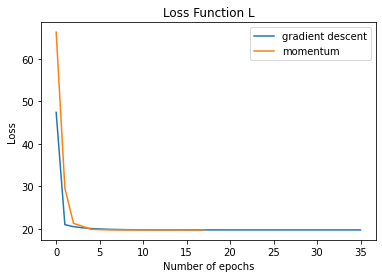

In [109]:
#Plot the loss function
plt.title('Loss Function L')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.plot(model1.loss_history, label='gradient descent')
plt.plot(model2.loss_history[:len(model1.loss_history)], label='momentum')
plt.legend()
plt.show()

### Plot the data with our model

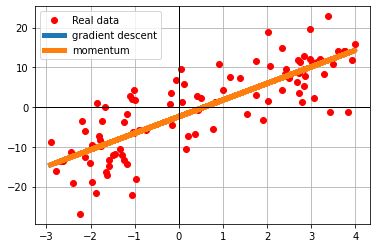

In [120]:
plt.plot(data_x, data_y, 'ro', label='Real data')
plt.plot(data_x, model1.w * data_x + model1.b, lw=5, label='gradient descent')
plt.plot(data_x, model2.w * data_x + model2.b, lw=5, label='momentum')
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)
plt.legend()
plt.grid()
plt.show()

## Plot loss surface function

In [121]:
# putting together our points to plot in a 3D plot
number_of_points = 50
margin = 4.
w_min = a - margin
w_max = a + margin
b_min = b - margin
b_max = b + margin
w_points = np.linspace(w_min, w_max, number_of_points) 
b_points = np.linspace(b_min, b_max, number_of_points)
w_mesh, b_mesh = np.meshgrid(w_points, b_points)
loss_ = np.array([model1.loss_for_plot(wps, bps) for wps, bps in zip(w_mesh, b_mesh)])

### Static 3D plot with learning path

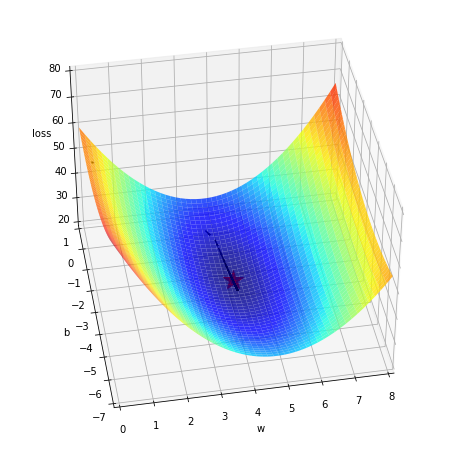

In [122]:
#%matplotlib inline
#%matplotlib notebook
#%pylab

path1 = model1.path
path2 = model2.path

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d', elev=40, azim=-100)

ax.plot_surface(w_mesh, 
                b_mesh, 
                loss_, 
                norm=LogNorm(), 
                rstride=1, 
                cstride=1, 
                edgecolor='none', 
                alpha=.8, 
                cmap=plt.cm.jet)

ax.plot(*minima, 
        model1.loss_for_plot(*minima), 
        'r*', 
        markersize=20)

ax.quiver(path1[0,:-1], 
          path1[1,:-1], 
          model1.loss_for_plot(*path1[::,:-1]),
          path1[0,1:]-path1[0,:-1], 
          path1[1,1:]-path1[1,:-1],
          model1.loss_for_plot(*path1[::,1:]) - model1.loss_for_plot(*path1[::,:-1]),
          color='k', 
          length=0.5, 
          normalize=True)

ax.set_xlabel('w')
ax.set_ylabel('b')
ax.set_zlabel('loss')

ax.set_xlim((w_min, w_max))
ax.set_ylim((b_min, b_max))

#plt.draw()
plt.show()

### Static contour plot with optimization path

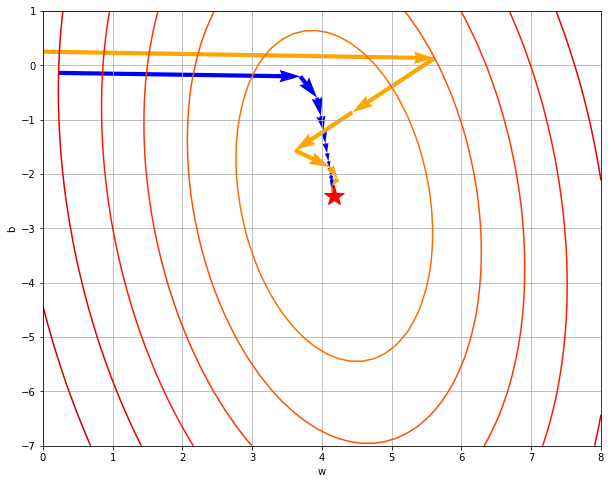

In [123]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.contour(w_mesh, 
           b_mesh, 
           loss_, 
           levels=np.logspace(-1, 2, 35), 
           norm=LogNorm(), 
           cmap=plt.cm.jet)
ax.plot(*minima, 'r*', markersize=20)

ax.quiver(path1[0,:-1], 
          path1[1,:-1], 
          path1[0,1:]-path1[0,:-1], 
          path1[1,1:]-path1[1,:-1],
          scale_units='xy', 
          angles='xy', 
          scale=1, 
          color='blue')
ax.quiver(path2[0,:-1], 
          path2[1,:-1], 
          path2[0,1:]-path2[0,:-1], 
          path2[1,1:]-path2[1,:-1],
          scale_units='xy', 
          angles='xy', 
          scale=1, 
          color='orange')

ax.set_xlabel('w')
ax.set_ylabel('b')

ax.set_xlim((w_min, w_max))
ax.set_ylim((b_min, b_max))

plt.grid()
plt.show()

### Animation contour plot with optimization path

In [124]:
class TrajectoryAnimation(animation.FuncAnimation):
  def __init__(self, *paths, labels=[], colors=[], fig=None, ax=None, frames=None, 
               interval=60, repeat_delay=5, blit=True, **kwargs):
    if fig is None:
      if ax is None:
        fig, ax = plt.subplots()
      else:
        fig = ax.get_figure()
    else:
      if ax is None:
        ax = fig.gca()

    self.fig = fig
    self.ax = ax

    self.paths = paths

    if frames is None:
      frames = max(path.shape[1] for path in paths)

    self.lines = [ax.plot([], [], label=label, color=color, lw=3)[0] 
                  for _, label, color in zip_longest(paths, labels, colors)]
    self.points = [ax.plot([], [], 'o', color=line.get_color())[0] 
                   for line in self.lines]

    super(TrajectoryAnimation, self).__init__(fig, self.animate, init_func=self.init_anim,
                                              frames=frames, interval=interval, blit=blit,
                                              repeat_delay=repeat_delay, **kwargs)

  def init_anim(self):
    for line, point in zip(self.lines, self.points):
      line.set_data([], [])
      point.set_data([], [])
    return self.lines + self.points

  def animate(self, i):
    for line, point, path in zip(self.lines, self.points, self.paths):
      line.set_data(*path[::,:i])
      point.set_data(*path[::,i-1:i])
    return self.lines + self.points

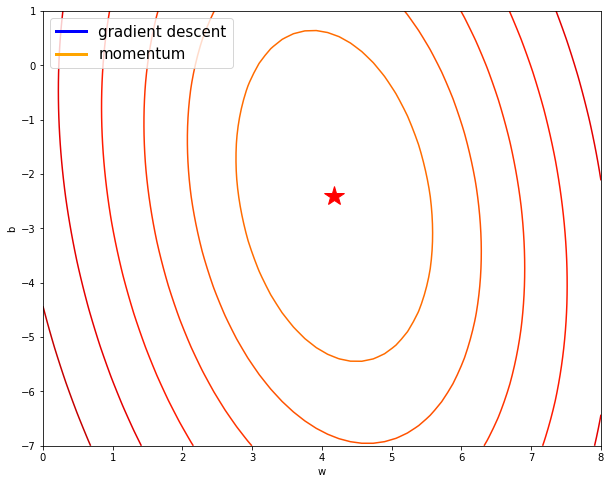

In [125]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.contour(w_mesh, b_mesh, loss_, levels=np.logspace(-1, 2, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima, 'r*', markersize=20)

ax.set_xlabel('w')
ax.set_ylabel('b')

ax.set_xlim((w_min, w_max))
ax.set_ylim((b_min, b_max))

all_pathes = [path1, path2]
opt_names = ['gradient descent', 'momentum']
colors = ['blue', 'orange']

#path_animation = TrajectoryAnimation(*all_pathes, labels=opt_names, colors=colors, ax=ax)
path_animation = TrajectoryAnimation(*all_pathes, labels=opt_names, colors=colors, ax=ax, interval=600)

ax.legend(loc='upper left', prop={'size': 15})

In [126]:
HTML(path_animation.to_html5_video())